In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Amazon Fine Food Reviews Analysis using Naive Bayes Classifier.

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

#### Basic information about the downloaded dataset<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Our main objective for this analysis is to train a model which can seperate the postive and negative reviews.
In this problem we will apply classification techniques called Naive Bayes to get an idea if the data can be seperated based on its polarity, i.e. if the review is positive or negative. By looking at the Score column we can make out that the review is positive or not. But we don't need to implement any ML here. A simple if-else condition will make us do this. So for this problem, we will put our focus on to the Review text. The text is the most important feature here if you may ask. Based on the review text we will build a prediction model and determine if a future review is positive or negative.

#### While pre-processing the original dataset we have taken into consideration the following points.

1. We will classify a review to be positive if and only if the corresponding Score for the given review is 4 or 5.
2. We will classify a review to be negative if and only if the corresponding Score for the given review is 1 or 2.
3. We will ignore the reviews for the time being which has a Score rating of 3. Because 3 can be thought of as a neutral review. It's neither negative nor positive.
4. We will remove the duplicate entries from the dataset.
5. For this problem we will consider a sample size of 50000 reviews sampled randomly from the original dataset. I have done this because I don't have a huge RAM size (12 GB to be specific). 
6. We will train our final mdel using four featurizations -> bag of words model, tf-idf model, average word-to-vec model and tf-idf weighted word-to-vec model.
7. So at end of the training the model will be trained on the above four featurizations to determine if a given review is positive or negative (Determining the sentiment polarity of the Amazon reviews)

In [2]:
#Importing all the neccessary libraries
%matplotlib inline
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn import datasets, neighbors
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from collections import Counter
from matplotlib.colors import ListedColormap
import scikitplot.metrics as sciplot
from sklearn.metrics import accuracy_score
import math
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

#### The immediate code block below does the following things :

1. Load the Amazon dataset.
2. Classify the reviews initially based on their score rating and give them a 'Positve' or a 'Negative' tag.
3. Remove duplicate/redundant datas.
4. Get an idea of how much percentage data were actually duplicates.
5. Plot a histogram which will display the distribution of the number of positive and negative reviews after de-duplication.

###### NOTE : If we dont' clean the data and feed them to an ML system, it basically means we are throwing in a lot of garbage data to the ML system. If we give it garbage, it will give us garbage back. So it's utmost important to clean the data before proceeding.

In [10]:
'''Loading the Amazon dataset, Remove duplicate data.'''
#Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews.
connection_sqlobject = sqlite3.connect('database.sqlite') 

#Filter only positive and negative reviews. Do nbot consider reviews with score = 3.
#not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, connection_sqlobject)

#Give reviews with Score > 3 a 'Positive' tag, and reviews with a score < 3 a 'Negative' tag.
filtered_data['SentimentPolarity'] = filtered_data['Score'].apply(lambda x : 'Positive' if x > 3 else 'Negative')
filtered_data['Class_Labels'] = filtered_data['SentimentPolarity'].apply(lambda x : 1 if x == 'Positive' else 0)

#Display information about the dataset before the removal of duplicate data.
print("The shape of the filtered matrix : {}".format(filtered_data.shape))
print("The median score values : {}".format(filtered_data['Score'].mean()))
print("The number of positive and negative reviews before the removal of duplicate data.")
print(filtered_data["SentimentPolarity"].value_counts())

#Removing duplicate entries based on past knowledge.
filtered_duplicates=filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.
final_data=filtered_duplicates[filtered_duplicates.HelpfulnessNumerator <= filtered_duplicates.HelpfulnessDenominator]

#Display information about the dataset after the removal of duplicate data.
print("\nThe shape of the data matrix after deduplication : {}".format(final_data.shape))
print("The median score values after deduplication : {}".format(final_data['Score'].mean()))
print("The number of positive and negative reviews after the removal of duplicate data.")
print(final_data["SentimentPolarity"].value_counts())

#Checking to see how much % of data still remains.
print("\nChecking to see how much percentage of data still remains.")
retained_per = (final_data['SentimentPolarity'].size*1.0)/(filtered_data['SentimentPolarity'].size*1.0)*100
removed_per = 100 - retained_per
print("Percentage of redundant data removed : {}".format(removed_per))
print("Percentage of original data retained : {}".format(retained_per))

#Display the first 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.
print("\nFirst 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.")
final_data.head(5)

The shape of the filtered matrix : (525814, 12)
The median score values : 4.27914813983652
The number of positive and negative reviews before the removal of duplicate data.
Positive    443777
Negative     82037
Name: SentimentPolarity, dtype: int64

The shape of the data matrix after deduplication : (364171, 12)
The median score values after deduplication : 4.27579626054793
The number of positive and negative reviews after the removal of duplicate data.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64

Checking to see how much percentage of data still remains.
Percentage of redundant data removed : 30.741478926008057
Percentage of original data retained : 69.25852107399194

First 5 rows of the final data matrix after de-duplication and intial processing of the original dataset.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,SentimentPolarity,Class_Labels
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Negative,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,Positive,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,Negative,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Positive,1


#### In this code block :

1. I am creating a copy of the final_data dataset called 'sampled_dataset' by dropping the unwanted columns that we don't need for this problem.
2. Sorting the data according to time, such that the oldest reviews are displayed at the top and the latest reviews are displayed at the bottom.
3. Displaying information about the number of postive and negative reviews in the sampled dataset, using a Histogram.

The shape of the sampled dataset after dropping unwanted columns :  (364171, 4)

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0
1,1351209600,Very pleased with the quality of the espresso....,Positive,1
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1
7,1351209600,try it & we shared with the familys/all han th...,Positive,1
8,1351209600,If you like butter flavor this is the best mic...,Positive,1
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1


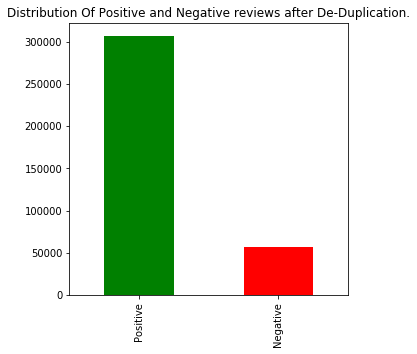

In [11]:
'''Creating a sampled dataset dropping the unwanted columns that we don't need for this problem, from the actual dataset.'''
#Creating a subset of the "final_data" table with randomly selecting 360000 samples
#sampled_dataset = final_data.sample(n=360000, replace=False, random_state=0).reset_index()
#print("\nThe shape of the sampled dataset : ", sampled_dataset.shape)

#Dropping unwanted columns for now.
sampled_dataset=final_data.drop(labels=['Id','ProductId', 'UserId', 'Score', 'ProfileName','HelpfulnessNumerator', 'HelpfulnessDenominator','Summary'], axis=1)
print("The shape of the sampled dataset after dropping unwanted columns : ", sampled_dataset.shape)

#Sorting data according to Time in ascending order => Time Based Splitting Step 1.
sampled_dataset=sampled_dataset.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
sampled_dataset = sampled_dataset.reset_index()
sampled_dataset=sampled_dataset.drop(labels=['index'], axis=1)

#Display distribution of Postive and Negative reviews in a bar graph
sampled_dataset["SentimentPolarity"].value_counts().plot(kind='bar',color=['green','red'],title='Distribution Of Positive and Negative reviews after De-Duplication.',figsize=(5,5))
sampled_dataset.head(5)

#Display the first 10 rows of the sampled_dataset (All the reviews are arranged according to time)
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

#### In this code block :

1. We define two functions which will remove the HTML tags and punctuations from each review.
2. At the end of this code block, each review will contain texts which will only contain alphabetical strings. 
3. We will apply techniques such as stemming and stopwords removal.
3. We will create two columns in the sampled dataset - 'CleanedText' and 'RemovedHTML'.
4. 'CleanedText' column will basically contain the data corpus after stemming the each reviews and removing stopwords from each review. We will use this for our Bag of Word model.
5. 'RemovedHTML' column will contain the data corpus from which only the HTML tags and punctuations are removed. We will use this column for our TF-IDF model, Average Word2Vec model and TF-IDF weighted average Word2Vec model.
6. Store the final table in a dataset called 'sampled_dataset' for future use.

In [12]:
'''Data Cleaning Stage. Clean each review from the sampled Amazon Dataset.'''
#Data Cleaning Stage. Clean each review from the sampled Amazon Dataset

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern,' ',sentence)
    return cleaned_text

#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc.
def removePunctuations(sentence):
    cleaned_text  = re.sub('[^a-zA-Z]',' ',sentence)
    return cleaned_text

#Stemming and stopwords removal
import re
from nltk.stem.snowball import SnowballStemmer
sno = SnowballStemmer(language='english')

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['not'])
custom_stopwords = default_stopwords - remove_not

#Building a data corpus by removing all stopwords except 'not'. Because 'not' can be an important estimator to differentiate between positive and negative reviews.    
count=0                   #Iterator to iterate through the list of reviews and check if a given review belongs to the positive or negative class
string=' '    
data_corpus=[]
all_positive_words=[] #Store all the relevant words from Positive reviews
all_negative_words=[] #Store all the relevant words from Negative reviews
stemed_word=''
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): #Checking if a word consists of only alphabets + word length is greater than 2.    
                if(cleaned_words.lower() not in custom_stopwords):
                    stemed_word=(sno.stem(cleaned_words.lower()))
                    filtered_sentence.append(stemed_word)
                    if (sampled_dataset['SentimentPolarity'].values)[count] == 'Positive': 
                        all_positive_words.append(stemed_word) #List of all the relevant words from Positive reviews
                    if(sampled_dataset['SentimentPolarity'].values)[count] == 'Negative':
                        all_negative_words.append(stemed_word) #List of all the relevant words from Negative reviews
                else:
                    continue
            else:
                continue 
    string = " ".join(filtered_sentence) #Final string of cleaned words    
    data_corpus.append(string) #Data corpus contaning cleaned reviews from the whole dataset
    count+=1
    
    
print("The length of the data corpus is : {}".format(len(data_corpus)))

#Building a data corpus by removing only the Punctuations and HTML tags. Stopwords are preserved. Words are not stemmed. This is useful for Average Word2Vec, TF-IDF W2V.
string=' '    
not_stemmed_corpus=[]
for review in sampled_dataset['Text'].values:
    filtered_sentence=[]
    sentence=removeHtml(review) #Remove HTMl tags
    for word in sentence.split():
        for cleaned_words in removePunctuations(word).split():
            if(cleaned_words.isalpha()): #Checking if a word consists of only alphabets    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    string = " ".join(filtered_sentence)    
    not_stemmed_corpus.append(string) 
    
#Adding a column of CleanedText to the table final which stores the data_corpus after pre-processing the reviews 
sampled_dataset['CleanedText']=data_corpus 

#Adding a column of PreserveStopwords to the table final which stores the data corpus in which stopwords are preserved and words are not stemmed.  
sampled_dataset['PreserveStopwords']=not_stemmed_corpus 

print("Printing the number of positive and negative reviews after data cleaning.")
print(sampled_dataset['SentimentPolarity'].value_counts())

#Store final table into an SQlLite table for future.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite')
c=connection_sqlobject.cursor()
connection_sqlobject.text_factory = str
sampled_dataset.to_sql('Reviews', connection_sqlobject, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

# Finding most frequently occuring Positive and Negative words 
freq_positive=nltk.FreqDist(all_positive_words)
freq_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_positive.most_common(20))
print("Most Common Negative Words : ",freq_negative.most_common(20))

#Display the first 10 rows of the sampled_dataset.
print("\nFirst 10 rows of the sampled_dataset.")
sampled_dataset.head(10)

The length of the data corpus is : 364171
Printing the number of positive and negative reviews after data cleaning.
Positive    307061
Negative     57110
Name: SentimentPolarity, dtype: int64
Most Common Positive Words :  [('not', 147661), ('like', 141051), ('tast', 131308), ('good', 113839), ('flavor', 111644), ('love', 107727), ('great', 104581), ('use', 104342), ('one', 97738), ('product', 92283), ('tri', 87158), ('tea', 84873), ('coffe', 79785), ('make', 75418), ('get', 72271), ('food', 65616), ('time', 56219), ('would', 55799), ('buy', 54320), ('realli', 52814)]
Most Common Negative Words :  [('not', 54587), ('tast', 35197), ('like', 32794), ('product', 28697), ('one', 20794), ('flavor', 20021), ('would', 18075), ('tri', 17798), ('use', 15369), ('good', 15188), ('coffe', 14899), ('get', 13801), ('buy', 13771), ('order', 13022), ('food', 12912), ('tea', 11790), ('even', 11115), ('box', 10949), ('amazon', 10159), ('time', 9932)]

First 10 rows of the sampled_dataset.


,Time,Text,SentimentPolarity,Class_Labels,CleanedText,PreserveStopwords
0,1351209600,I just got this coffee a few days ago. I had c...,Negative,0,got coffe day ago coffe bean yesterday today m...,i just got this coffee a few days ago i had co...
1,1351209600,Very pleased with the quality of the espresso....,Positive,1,pleas qualiti espresso pod sturdi enough withs...,very pleased with the quality of the espresso ...
2,1351209600,Bought this with my new Oster Belgium waffle m...,Positive,1,bought new oster belgium waffl maker best waff...,bought this with my new oster belgium waffle m...
3,1351209600,We drink a lot of tea... from all over the wor...,Negative,0,drink lot tea world far worst tast tea purchas...,we drink a lot of tea from all over the world ...
4,1351209600,I have always bought my pure vanilla extract i...,Positive,1,alway bought pure vanilla extract mexico got t...,i have always bought my pure vanilla extract i...
5,1351209600,"From the label on the Cadbury Screme Egg: ""ALL...",Positive,1,label cadburi screme egg allergi inform manufa...,from the label on the cadbury screme egg aller...
6,1351209600,"Best soup mix I've tried. I love making soup, ...",Positive,1,best soup mix tri love make soup best tast eas...,best soup mix i ve tried i love making soup an...
7,1351209600,try it & we shared with the familys/all han th...,Positive,1,tri share famili han thumb cut good lite oliv ...,try it we shared with the familys all han thum...
8,1351209600,If you like butter flavor this is the best mic...,Positive,1,like butter flavor best microwav popcorn avail...,if you like butter flavor this is the best mic...
9,1351209600,I love all sorts of teas. My friends know this...,Positive,1,love sort tea friend know travel often bring t...,i love all sorts of teas my friends know this ...


### In this code block : 

1. We define a function which is used to perform column standardization on any give input matrix.
2. We define a function which is used to get the top 50 features from both the negative and the positive review classes.
3. We define a function which is used to measure the various performance metrics for a given model. We will use accuracy as a metric to evaluate this models performance on unseen data.
4. We define a function which is used to obtain the optima value of alpha along with the best mnodel estimator, using time series cross validation along with grid search CV.
5. We define a function which is used to plot and visually represent the errors vs hyperparameter plot.
6. We fit the naive base classifier to our training data and make the final model.

In [1]:
def standardize(X_train_vectors, X_test_vectors):
    '''Function used to column standardize any given matrix'''
    from sklearn.preprocessing import StandardScaler
    scalar = StandardScaler(with_mean=False)
    scalar.fit(X_train_vectors)
    X_train_vectors = scalar.transform(X_train_vectors)
    X_test_vectors = scalar.transform(X_test_vectors)
    print("The shape of the X_train_vectors is : {}".format(X_train_vectors.shape))
    print("The shape of the X_test_vectors is : {}".format(X_test_vectors.shape))
    return (X_train_vectors, X_test_vectors)

def top_features(nb_classifier, vectorizer_object):
    '''Get top 50 features displayed from both the negative and the positive review classes.'''
    neg_class_prob_sorted = (-nb_classifier.feature_log_prob_[0, :]).argsort()               #Note : Putting a - sign indicates the indexes will be sorted in descending order.
    pos_class_prob_sorted = (-nb_classifier.feature_log_prob_[1, :]).argsort()
    neg_class_features = np.take(vectorizer_object.get_feature_names(), neg_class_prob_sorted[:50])
    pos_class_features = np.take(vectorizer_object.get_feature_names(), pos_class_prob_sorted[:50])
    print("The top 50 most frequent words from the positive class are :\n")
    print(pos_class_features)
    print("\nThe top 50 most frequent words from the negative class are :\n")
    print(neg_class_features)
    del(neg_class_prob_sorted, pos_class_prob_sorted, neg_class_features, pos_class_features)

def performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse): #MSE : Mean Squared Loss
    '''Function to measure the various performance metrics for a given model.'''
    print("\n'''PERFORMANCE EVALUATION'''")
    print("\n\nDetailed report for the {} Vectorization.".format(vectorizationType))

    #Predict the labels for the test set.
    y_pred = nb_classifier.predict(X_test)
    
    #Evaluate the accuracy of the model on test set
    test_accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100
    points = accuracy_score(y_test, y_pred, normalize=False)
    print('\nThe number of accurate predictions out of {} data points on unseen data is {}'.format(X_test.shape[0], points))
    print('Accuracy of the {} model on unseen data is {} %'.format(vectorizationType, np.round(test_accuracy,2)))
    
    #Get the precision, recall and F1 score for this model.
    print("Precision of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.precision_score(y_test ,y_pred),4)))
    print("Recall of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.recall_score(y_test ,y_pred),4)))
    print("F1 score of the {} model on unseen data is {}".format(vectorizationType, np.round(metrics.f1_score(y_test ,y_pred),4)))
    
    #Classification Report
    print ('\nClasification report for {} model : \n'.format(vectorizationType))
    print(metrics.classification_report(y_test,y_pred))
    
    #Print the Conclusions on the trained dataset
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    p = tp+fn #p = total number of actual postives
    n = fp+tn #p = total number of actual negatives
    TPR = tp/p ; TNR = tn/n ; FPR = fp/n ; FNR = fn/p
    print("\nThe True Positives Rate is : {}".format(TPR))
    print("The True Negatives Rate is : {}".format(TNR))
    print("The False Positives Rate is : {}".format(FPR))
    print("The False Negatives Rate is : {}".format(FNR))
    
    #Inference
    print("\nOf all the reviews that the model has predicted to be positive, {}% of them are actually positive.".format(np.round(metrics.precision_score(y_test ,y_pred)*100,2)))
    print("Of all the reviews that are actually positive, the model has predicted {}% of them to be positive.".format(np.round(metrics.recall_score(y_test ,y_pred)*100,2)))
      
    #Save the below list for later use to display model information
    info_model_NB = [vectorizationType, optimal_alpha, np.round(np.array(mse).mean(),4), np.round(1-metrics.accuracy_score(y_test, y_pred),4), np.round(metrics.f1_score(y_test ,y_pred),4), points]
    with open('info_model_NB.txt', 'a') as filehandle:  
        filehandle.writelines("%s " % iterator for iterator in info_model_NB)
        filehandle.writelines("\n")
        
    #Get the confusion matrix for the running model
    print("\nFind below the confusion matrix for {} model.".format(vectorizationType))
    sciplot.plot_confusion_matrix(y_test ,y_pred)
    
    #Free memory allocations
    del(X_train, y_train, X_test, y_test, vectorizationType, y_pred, nb_classifier)
       
def get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test):
    '''This function will determine the best hyperparameters using TimeSeriesSplit CV and Grid Search, using 10 fold cross validation. '''
    from sklearn.model_selection import TimeSeriesSplit
    alphas = np.logspace(-5, 4, 100)
    tuned_parameters = [{'alpha': alphas}]
    n_folds = 10
    model = MultinomialNB()
    my_cv = TimeSeriesSplit(n_splits=n_folds).split(X_train)
    gsearch_cv = GridSearchCV(estimator=model, param_grid=tuned_parameters, cv=my_cv, scoring='f1', n_jobs=6)
    gsearch_cv.fit(X_train, y_train)
    print("\nGridSearchCV completed for {} model!".format(vectorizationType))
    print("Best estimator for {} model : ".format(vectorizationType), gsearch_cv.best_estimator_)
    print("Best Score for {} model : ".format(vectorizationType), gsearch_cv.best_score_)
    return gsearch_cv
    
def plot_errors(gsearch_cv):
    '''This function is used to plot the curve for mean squared errors vs alpha values'''
    #Get cross validation scores. Here we obtain the alpha values and their corresponding mean test scores.
    cv_result = gsearch_cv.cv_results_         
    mts = cv_result["mean_test_score"]        #list that will hold the mean of cross validation accuracy scores for each alpha
    alphas = cv_result["params"]

    alpha_values = []                         #list that will hold all the alpha values that the grid search cross validator tried.
    for i in range(0,len(alphas)):
        alpha_values.append(alphas[i]["alpha"])

    #Changing accuracy to mean squared error. **error = 1 - accuracy ; error = Cross Validation Errors, accuracy = Cross Validation accuracy
    mse = [1 - x for x in mts]

    #Determining best alpha from errors. 'alpha' will be best for the lowest value for error
    optimal_alpha = alpha_values[mse.index(min(mse))] #Laplace smoothing
    print('The optimal value of alpha is : {}'.format(optimal_alpha))     

    #Plot error vs alpha values
    plt.figure(figsize=(35,8))
    plt.plot(alpha_values , mse, color='green', linestyle='dashed', linewidth=2, marker='o', markerfacecolor='red', markersize=10)
    for xy in zip(alpha_values, np.round(mse,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title('Plot for Errors vs Alpha Values')
    plt.xlabel('Values of Alpha')
    plt.ylabel('Errors')
    plt.show()
    
    return (optimal_alpha,mse)
    
def naive_bayes_algorithm(X_train, y_train, X_test, y_test, vectorizationType, vectorizer_object):
    '''This function splits the dataset into training set and test sets. The test data remains untouched.
    A time series 10 fold cross validation is performed on the train data and the value of optimal alpha is calculated. 
    The dataset is then trained with this value of optimal alpha. 
    Finally the Naive Bayes model is used to predict its accuracy on the future unseen test set.'''
    
    #Perform 10-fold cross validation on the train set
    print("Starting Cross Validation steps...")
    gsearch_cv = get_GridSearchCV_estimator(vectorizationType, X_train, y_train, X_test, y_test)
    
    #Plot the graphical representation of the mean squared error vs the alpha values obtained during cross validation.
    optimal_alpha, mse = plot_errors(gsearch_cv)

    #Initialize the Naive Bayes constructor using alpha = optimal_alpha
    nb_classifier = gsearch_cv.best_estimator_

    #Fit the model to the train set using optimal alpha
    nb_classifier.fit(X_train, y_train)
    
    #Display the top features of both the negative and positive reviews
    top_features(nb_classifier, vectorizer_object)
    
    #Evaluate the model's performance
    performance(nb_classifier, vectorizationType, X_train, y_train, X_test, y_test, optimal_alpha, mse)

### Naive Bayes on the Bag of Words model created using 'CleanedText'.

A bag-of-words model, or BoW for short, is a way of extracting features from text for use in modeling, such as with machine learning algorithms.
The approach is very simple and flexible, and can be used in a myriad of ways for extracting features from documents. Suppose we have N reviews in our dataset and we want to convert the words in our reviews to vectors. We can use BOW as a method to do this. What it does is that for each unique word in the data corpus, it creates a dimension. Then it counts how many number of times a word is present in a review. And then this number is placed under that word for a corresponding review. We will get a Sparse Matrix representation for all the worods inthe review.

Let's look at this example of 2 reviews below :

r1 = {"The food is great, ambience is great"} and  </br>r2 = {"I love this food"}

At first the words will be extracted from r1 and r2.

r1' = {"The", "food", "is", "great", "ambience", "is", "great"} and r2' = {"I", "love", "this", "food"}

Now using r1' and r2' we will create a vector of unique words -> V =  {"The", "food", "is", "great", "ambience", "I", "love", "this"}

Now here's how the vector representation will look like for each reviews r1 and r2, when we make use of the vector 'V' created above.

r1_vector = [1,1,2,2,1,0,0,0] and r2_vector = [0,1,0,0,0,1,1,1]

In r1 since, "great" and "is" occurs twice, we have set the count to 2. If a words doesn't occur in a review we will set the count to 0. Although "is" a stopword, the example above is intended to make you understand how bag of words work.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (291336, 64001)
The shape of the X_test_vectors is : (72835, 64001)
Starting Cross Validation steps...

GridSearchCV completed for Bag-of-Words model!
Best estimator for Bag-of-Words model : 
 MultinomialNB(alpha=10000.0, class_prior=None, fit_prior=True)
Best Score for Bag-of-Words model :  0.9070512181636785
The optimal value of alpha is : 10000.0


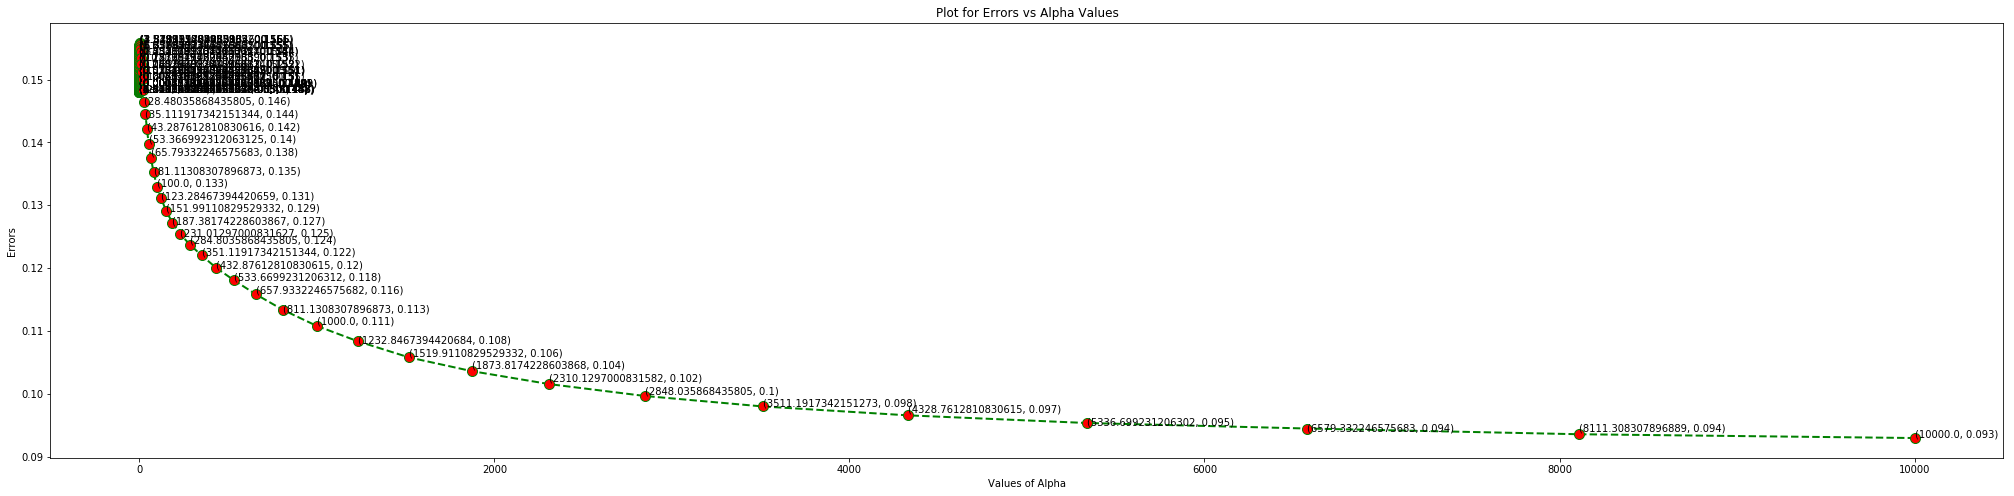

The top 50 most frequent words from the positive class are :

['love' 'great' 'good' 'like' 'not' 'tast' 'tri' 'one' 'use' 'flavor'
 'make' 'get' 'product' 'best' 'time' 'buy' 'find' 'realli' 'much' 'price'
 'also' 'littl' 'would' 'well' 'store' 'recommend' 'amazon' 'eat' 'better'
 'order' 'delici' 'even' 'year' 'found' 'high' 'favorit' 'day' 'enjoy'
 'perfect' 'nice' 'give' 'want' 'need' 'first' 'keep' 'work' 'way' 'sweet'
 'bit' 'sinc']

The top 50 most frequent words from the negative class are :

['not' 'tast' 'product' 'like' 'disappoint' 'would' 'one' 'buy' 'bad'
 'tri' 'money' 'even' 'return' 'order' 'wast' 'thought' 'review' 'flavor'
 'get' 'look' 'bought' 'purchas' 'receiv' 'worst' 'good' 'box' 'aw'
 'could' 'packag' 'horribl' 'terribl' 'away' 'much' 'amazon' 'first'
 'know' 'say' 'time' 'think' 'want' 'got' 'someth' 'use' 'item' 'never'
 'realli' 'open' 'made' 'threw' 'hope']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bag-of-Words Vectorization.

The number of ac

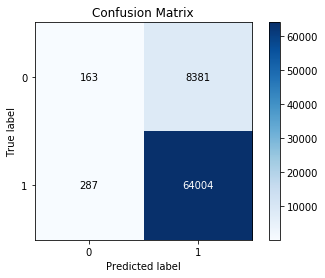

In [4]:
'''Creating the Bag of Words vector for the cleaned reviews.'''
#Bag of Words model creation using cleaned text 

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the BOW constructor
cv_object = CountVectorizer().fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = cv_object.transform(X_train)
X_test_vectors = cv_object.transform(X_test)

#Colum Standardization of the Bag of Words vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations. 
del(sampled_dataset, X, y, X_train, X_test)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bag-of-Words", cv_object)

### Naive Bayes on the TF-IDF model created using 'CleanedText' texts. 

In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

Let's assume we have data corpus D, which contains N reviews {r1,r2,r3,r4...rN}. Let's say our review r1 contains the following words {w1,w2,w3,w1,w9,w6,w7,w9,w9}.

TF or Term Frequency for a word is basically the number of times a word occurs in a review divided by the total number of words present in that same review.
For example, in the text corpus that we have considered in the above example, the TF for word w1 is (2/9) and for word w9 is (1/3). Intuitively, higher the occurence of a word in a text is, greater will be its TF value. TF values lies between 0 and 1.

IDF or Inverse Document Frequency for a word is given by the formula log(N/n), where 'N' is equal to the total number of reviews in the corpus 'D' and 'n' refers to the number of reviews in 'D' which contains that specific word. Intuitively, IDF will be higher for words which occur rarely and will be less for words which occurs more frequently. IDF values are more than 0.

So for each word in each review we will consider the product of (TF x IDF), and represent it in a d dimensional vector. 

TF-IDF basically doesn't consider the semantic meaning of words. But what is does is that it gives more importance to words which occurs less frequently in the whole data corpus and also gives much importance to the most frequent words that occurs in each review.


Creating the BOW vectors using the cleaned corpus
The shape of the X_train_vectors is : (291336, 64001)
The shape of the X_test_vectors is : (72835, 64001)
Starting Cross Validation steps...

GridSearchCV completed for TF-IDF model!
Best estimator for TF-IDF model : 
 MultinomialNB(alpha=10000.0, class_prior=None, fit_prior=True)
Best Score for TF-IDF model :  0.9080523128854529
The optimal value of alpha is : 10000.0


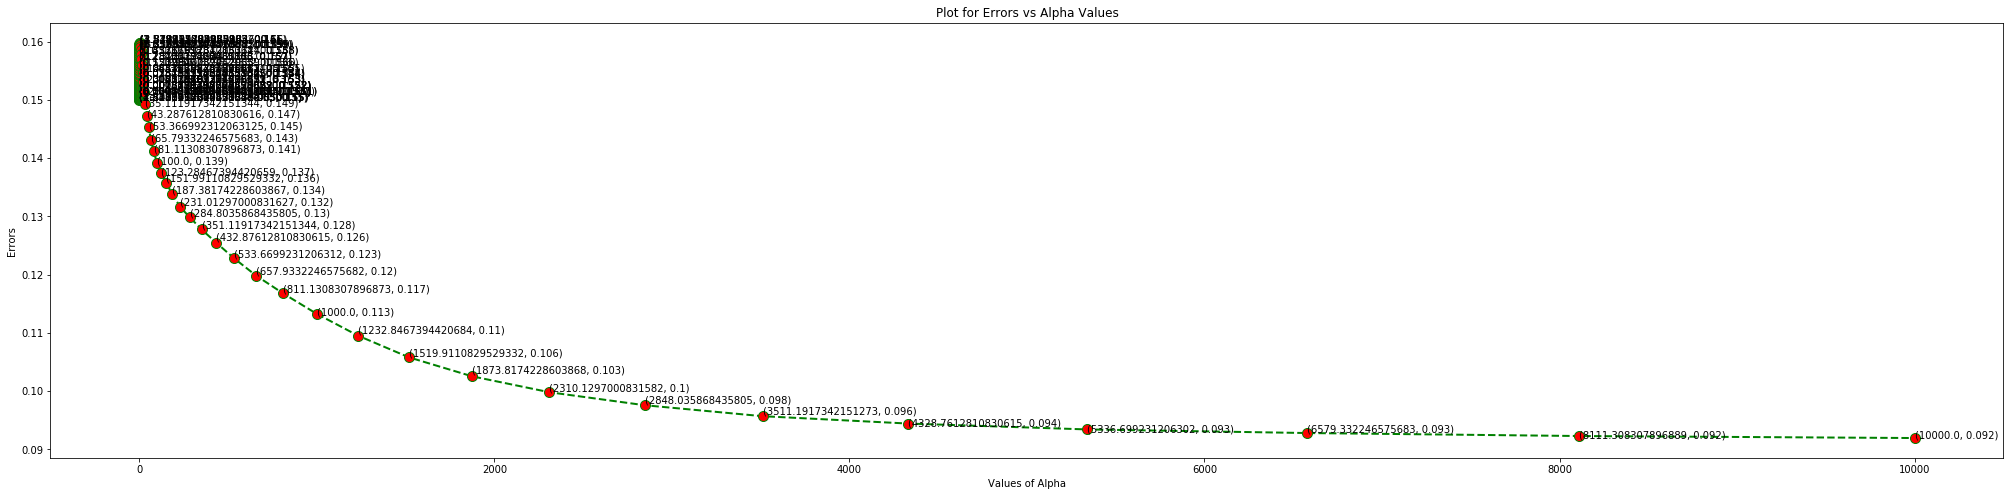

The top 50 most frequent words from the positive class are :

['love' 'like' 'great' 'good' 'tast' 'not' 'use' 'flavor' 'one' 'tri'
 'make' 'product' 'get' 'time' 'best' 'buy' 'price' 'realli' 'also' 'find'
 'amazon' 'would' 'much' 'littl' 'well' 'store' 'eat' 'coffe' 'order'
 'recommend' 'food' 'better' 'day' 'year' 'delici' 'even' 'high' 'found'
 'tea' 'favorit' 'enjoy' 'drink' 'nice' 'sweet' 'give' 'perfect' 'first'
 'work' 'want' 'mix']

The top 50 most frequent words from the negative class are :

['not' 'tast' 'like' 'disappoint' 'product' 'would' 'bad' 'one' 'return'
 'tri' 'wast' 'money' 'even' 'review' 'buy' 'flavor' 'thought' 'box' 'get'
 'order' 'worst' 'look' 'horribl' 'aw' 'terribl' 'away' 'receiv' 'bought'
 'packag' 'open' 'purchas' 'first' 'threw' 'could' 'think' 'much' 'mayb'
 'know' 'smell' 'refund' 'use' 'someth' 'read' 'good' 'say' 'ingredi'
 'bag' 'never' 'want' 'item']

'''PERFORMANCE EVALUATION'''


Detailed report for the TF-IDF Vectorization.

The number of accu

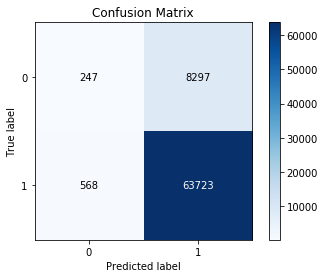

In [5]:
'''TF-IDF model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['CleanedText']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tf_idf_object = TfidfVectorizer(ngram_range=(1,1)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using the cleaned corpus")
X_train_vectors = tf_idf_object.transform(X_train)
X_test_vectors = tf_idf_object.transform(X_test)

#Colum Standardization of the TF-IDF vector created using cleaned data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "TF-IDF", tf_idf_object)

###  Naive Bayes on the Bigrams model created using 'PreserveStopwords':

A bigram or digram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. A bigram is an n-gram for n=2. The frequency distribution of every bigram in a string is commonly used for simple statistical analysis of text in many applications, including in computational linguistics, cryptography, speech recognition, and so on. In a bigram representation of sentences the relationship between two adjacent words are taken into consideration along with single words.


Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (291336, 2493105)
The shape of the X_test_vectors is : (72835, 2493105)
Starting Cross Validation steps...

GridSearchCV completed for Bi-Grams model!
Best estimator for Bi-Grams model : 
 MultinomialNB(alpha=4328.7612810830615, class_prior=None, fit_prior=True)
Best Score for Bi-Grams model :  0.9106538988769135
The optimal value of alpha is : 4328.7612810830615


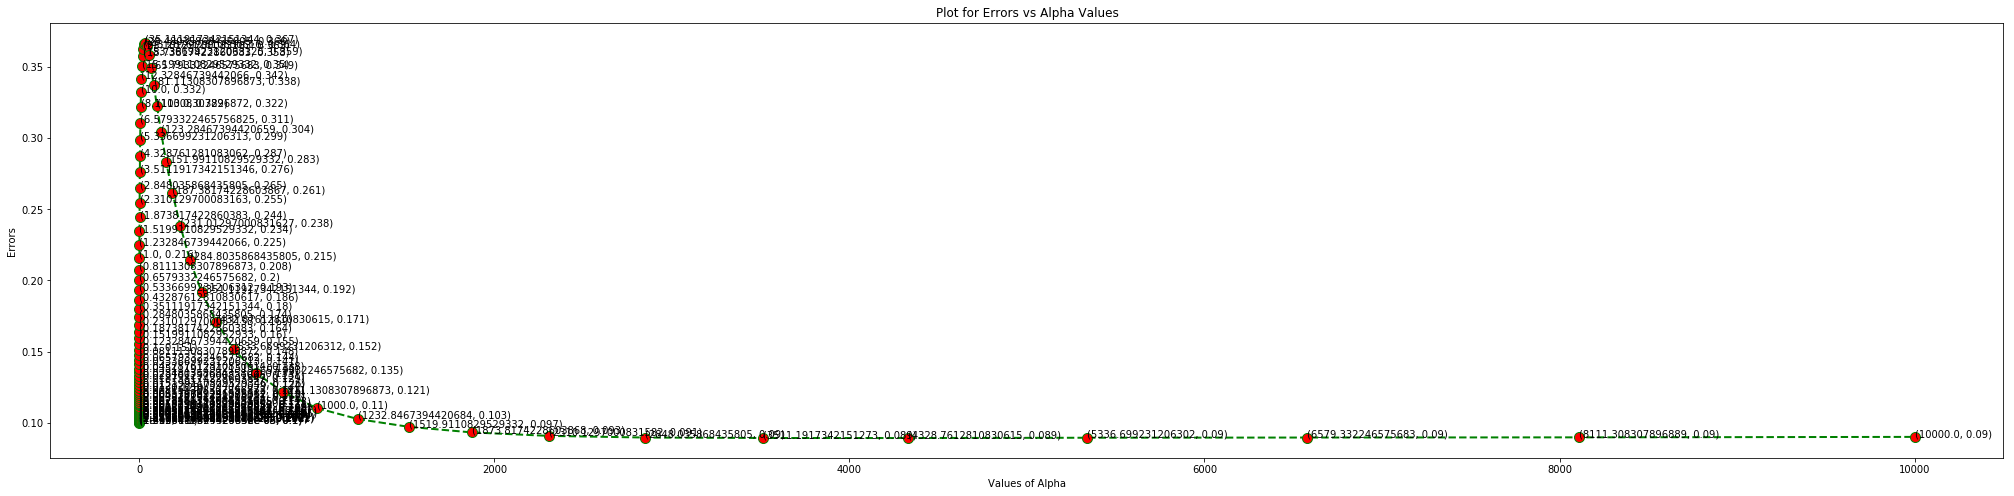

The top 50 most frequent words from the positive class are :

['and' 'the' 'to' 'this' 'it' 'is' 'of' 'for' 'in' 'my' 'with' 'but'
 'have' 'that' 'on' 'so' 'you' 'are' 'great' 'good' 'not' 'as' 'like'
 'they' 'these' 'was' 'can' 'at' 'just' 'or' 'be' 'very' 'love' 'one' 'if'
 'this is' 'them' 'all' 'when' 'taste' 'more' 'will' 'has' 'from' 'flavor'
 'in the' 'of the' 'product' 'it is' 'than']

The top 50 most frequent words from the negative class are :

['the' 'and' 'not' 'to' 'this' 'of' 'it' 'was' 'but' 'is' 'that' 'in'
 'for' 'like' 'be' 'my' 'have' 'taste' 'with' 'had' 'would' 'product' 'on'
 'they' 'of the' 'if' 'from' 'all' 'what' 'at' 'so' 'were' 'disappointed'
 'just' 'bad' 'you' 'one' 'no' 'there' 'as' 'even' 'it was' 'money' 'out'
 'don' 'did' 'are' 'in the' 'when' 'very']

'''PERFORMANCE EVALUATION'''


Detailed report for the Bi-Grams Vectorization.

The number of accurate predictions out of 72835 data points on unseen data is 64887
Accuracy of the Bi-Grams model on unseen

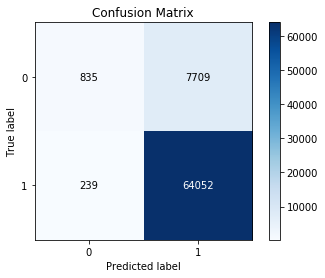

In [6]:
'''Bi Grams model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.'''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
bigrams_object = TfidfVectorizer(ngram_range=(1,2)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = bigrams_object.transform(X_train)
X_test_vectors = bigrams_object.transform(X_test)

#Colum Standardization of the T-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Bi-Grams", bigrams_object)

### Naive Bayes on the Tri-grams model created using 'PreserveStopwords':

Trigrams are a special case of the n-gram, where n is 3. They are often used in natural language processing for performing statistical analysis of texts and in cryptography for control and use of ciphers and codes. For this below code, the relationship between two and three adjacent words are taken into consideration. Single words are omitted.


Creating the BOW vectors using PreserveStopwords corpus
The shape of the X_train_vectors is : (291336, 11580701)
The shape of the X_test_vectors is : (72835, 11580701)
Starting Cross Validation steps...

GridSearchCV completed for Tri-Grams model!
Best estimator for Tri-Grams model : 
 MultinomialNB(alpha=1e-05, class_prior=None, fit_prior=True)
Best Score for Tri-Grams model :  0.905325964219732
The optimal value of alpha is : 1e-05


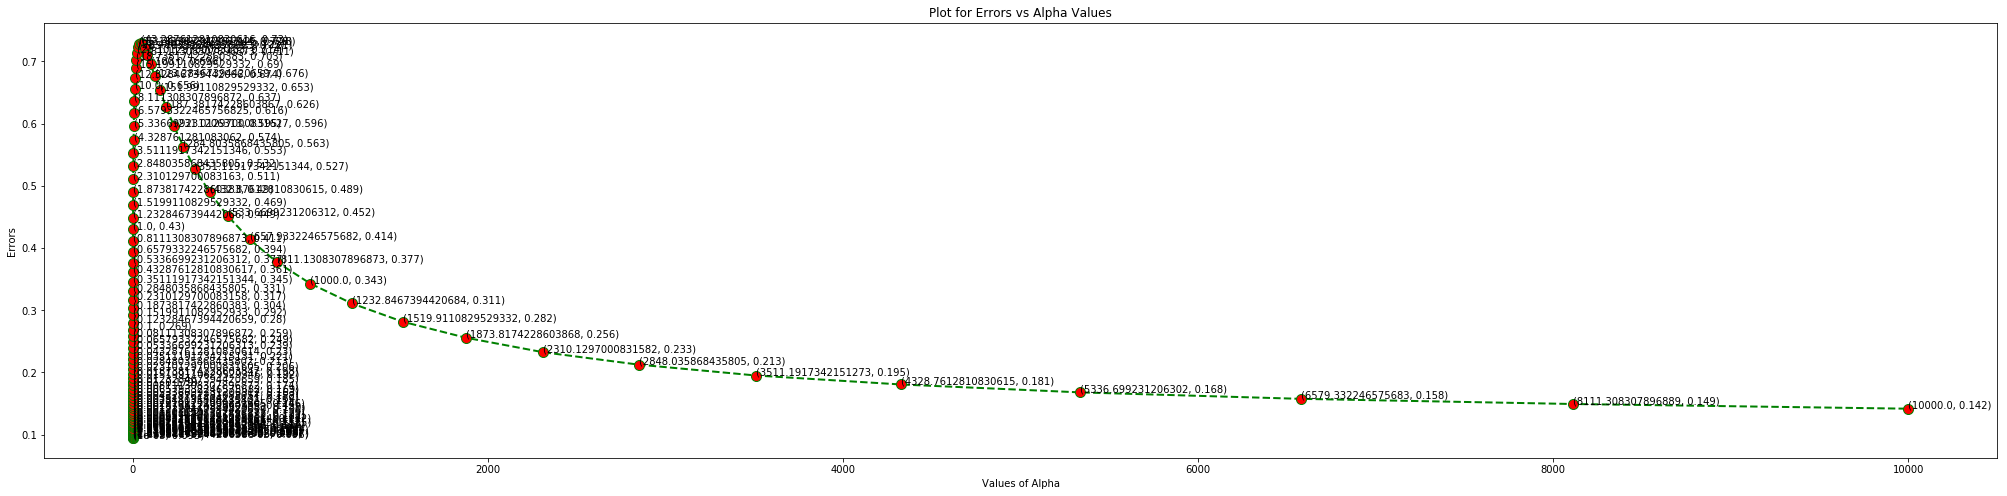

The top 50 most frequent words from the positive class are :

['this is' 'in the' 'of the' 'it is' 'if you' 'the best' 'and the'
 'they are' 'is the' 'and it' 'on the' 'this product' 'for the' 'to the'
 'to be' 'with the' 'in my' 'it was' 'you can' 'is great' 'to find'
 'have to' 'these are' 'the price' 'one of' 'for my' 'to make' 'and they'
 'but it' 'it in' 'to get' 'it has' 'love this' 'is very' 'of this'
 'at the' 'the taste' 'all the' 'this is the' 'have been' 'like the'
 'the only' 'my favorite' 'that it' 'on amazon' 'as well' 'the flavor'
 'and have' 'easy to' 'to have']

The top 50 most frequent words from the negative class are :

['of the' 'it was' 'in the' 'this product' 'at all' 'very disappointed'
 'is not' 'would not' 'did not' 'not buy' 'on the' 'to be' 'will not'
 'the worst' 'do not' 'to the' 'the same' 'the product' 'was not'
 'your money' 'waste of' 'not recommend' 'if you' 'it is' 'not worth'
 'but the' 'would be' 'and the' 'the box' 'the taste' 'had to' 'this is'
 

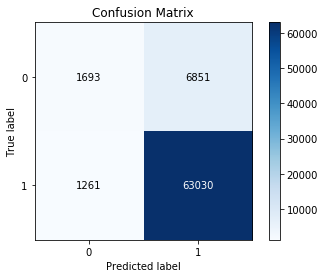

In [7]:
'''Tri-Grams model creation using text reviews. HTML tags and punctuations are removed. All stopwords are preserved.
This model won't contain single words. This will mostly try to figure out the relationships between consecutive words in a sentences '''

#Using the SQLite Table to read data from a previosuly saved table.
connection_sqlobject = sqlite3.connect('sampled_dataset_all_reviews.sqlite') 
sampled_dataset = pd.read_sql_query(""" SELECT * FROM Reviews """, connection_sqlobject)

#Split the data set into train and test sets. The test set should be unseen. Time Based Splitting Step 2.
#The top old 80% data will get into the train set. The latest 20% data will get into the test set.
X = sampled_dataset['PreserveStopwords']
y = sampled_dataset['Class_Labels']
split = math.floor(0.8*len(X))
X_train = X[0:split,] ; y_train = y[0:split,]
X_test = X[split:,] ; y_test = y[split:,]

#Initializing the TF-IDF contructor
tri_grams_object = TfidfVectorizer(ngram_range=(2,3)).fit(X_train)

#Creating the BOW matrix from cleaned data corpus. Only 'not' is preserved from stopwords. This is done for both train and test Vectors.
print("\nCreating the BOW vectors using PreserveStopwords corpus")
X_train_vectors = tri_grams_object.transform(X_train)
X_test_vectors = tri_grams_object.transform(X_test)

#Colum Standardization of the tri-gram vector created using preserved stopwords data. This is done for both train and test Vectors.
X_train_vectors, X_test_vectors = standardize(X_train_vectors, X_test_vectors)

#Free memory allocations.
del(sampled_dataset, X, y)

#Fitting the Naive Bayes to the BOW model
naive_bayes_algorithm(X_train_vectors, y_train, X_test_vectors, y_test, "Tri-Grams", tri_grams_object)

### Conclusion : 

From the below comparison chart we can see get an idea aboout how the different vectorizers perform.

In [8]:
#Compare performance and display it on a pretty table.
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ["Model", " Hyper-Parameter Value (alpha=)", "Train Error", "Test Error", "F1-Score", "No. Of accurate predictions"]

print("Please find below the important metrics for all the models below.\n")
file = open('info_model_NB.txt', 'r')
file.seek(0)
for line in file:
    table.add_row(line.split())
print(table)

Please find below the important metrics for all the models below.

+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
|    Model     |  Hyper-Parameter Value (alpha=) | Train Error | Test Error | F1-Score | No. Of accurate predictions |
+--------------+---------------------------------+-------------+------------+----------+-----------------------------+
| Bag-of-Words |             10000.0             |    0.1414   |   0.119    |  0.9366  |            64167            |
|    TF-IDF    |             10000.0             |    0.1444   |   0.1217   |  0.935   |            63970            |
|   Bi-Grams   |        4328.7612810830615       |    0.1729   |   0.1091   |  0.9416  |            64887            |
|  Tri-Grams   |              1e-05              |    0.3244   |   0.1114   |  0.9395  |            64723            |
+--------------+---------------------------------+-------------+------------+----------+------------